In [58]:
# python stuff
import os
import sys
sys.path.insert(0, '/home/lorenzocapelli/repos/peepholelib/peepholelib')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abc  
from pathlib import Path
import pandas as pd
from contextlib import ExitStack

# math stuff
from sklearn.metrics import roc_auc_score

# Our stuff
from peepholelib.datasets.cifar import Cifar
from peepholelib.models.model_wrap import ModelWrap 
from peepholelib.coreVectors.coreVectors import CoreVectors 

from peepholelib.utils.testing import trim_dataloaders

# torch stuff
import torch
from tensordict import TensorDict
from tensordict import MemoryMappedTensor as MMT
from torchvision.models import vgg16, VGG16_Weights
from cuda_selector import auto_cuda
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import functools

In [59]:
use_cuda = torch.cuda.is_available()
device = torch.device(auto_cuda('utilization')) if use_cuda else torch.device("cpu")
print(f"Using {device} device")

#--------------------------------
# Directories definitions
#--------------------------------

results_path = '/srv/newpenny/atk-detection/results/ml'
        
#--------------------------------
# Attacks
#--------------------------------

atk_list = ['PGD','BIM','CW', 'DeepFool']

#--------------------------------
# Detectors
#--------------------------------

detector_list = ['OCSVM','LOF','IF','MD']
      
#--------------------------------
# Layers selection 
#--------------------------------

target_layers = [
        'features.14',
         'features.28',
        'classifier.0',
        'classifier.3',
        # 'features.7',
        
        
        ]   


Using cuda:1 device


# USEless stuff


 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/toy_case/corevectors/CIFAR100/vgg16/corevectors.train exists. Loading from disk.
loaded n_samples:  400

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/toy_case/corevectors/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  100

 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/toy_case/corevectors/CIFAR100/vgg16/corevectors.train exists. Loading from disk.
loaded n_samples:  400

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/toy_case/corevectors/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  100

 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/toy_case/corevectors/CIFAR100/vgg16/corevectors.train exists. Loading from disk.
loaded n_samples:  400

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/toy_case/corevectors/CIFAR100/vgg16/corevectors.test exists. Load

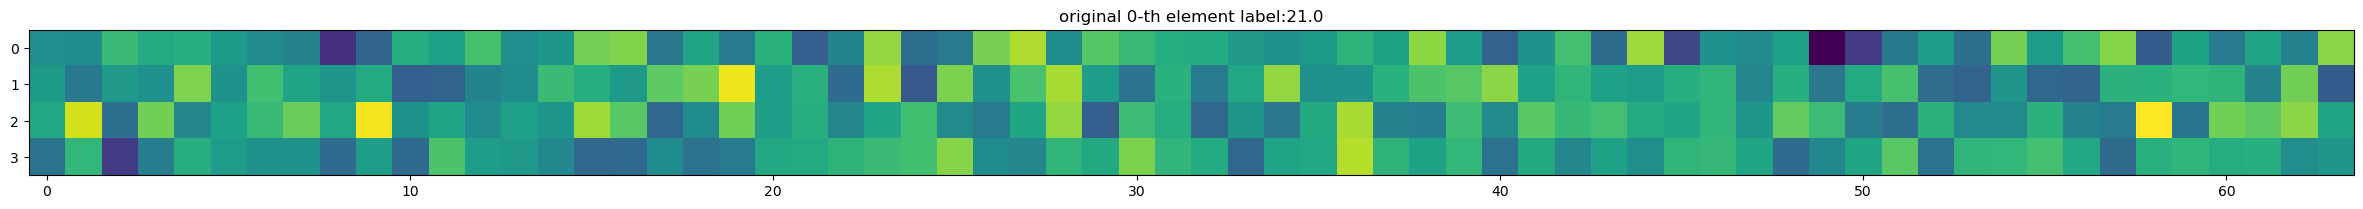

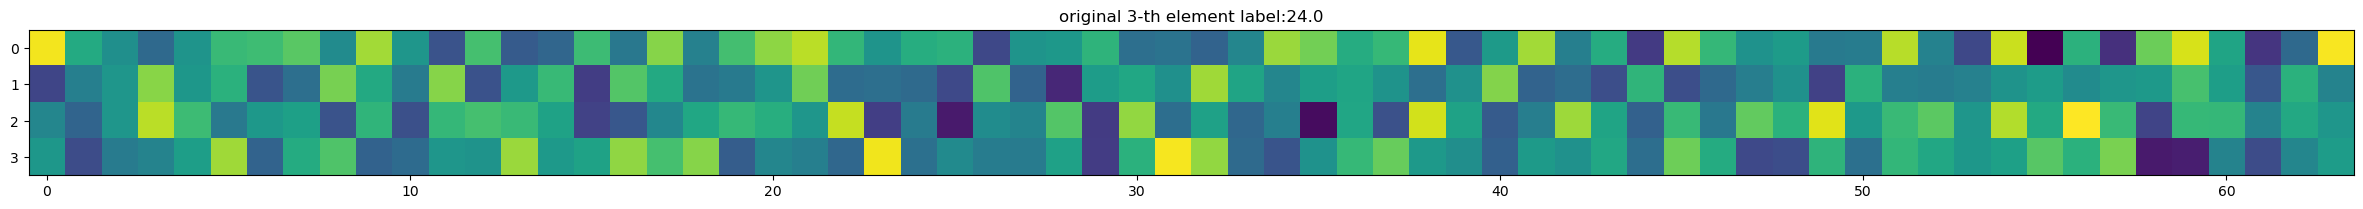

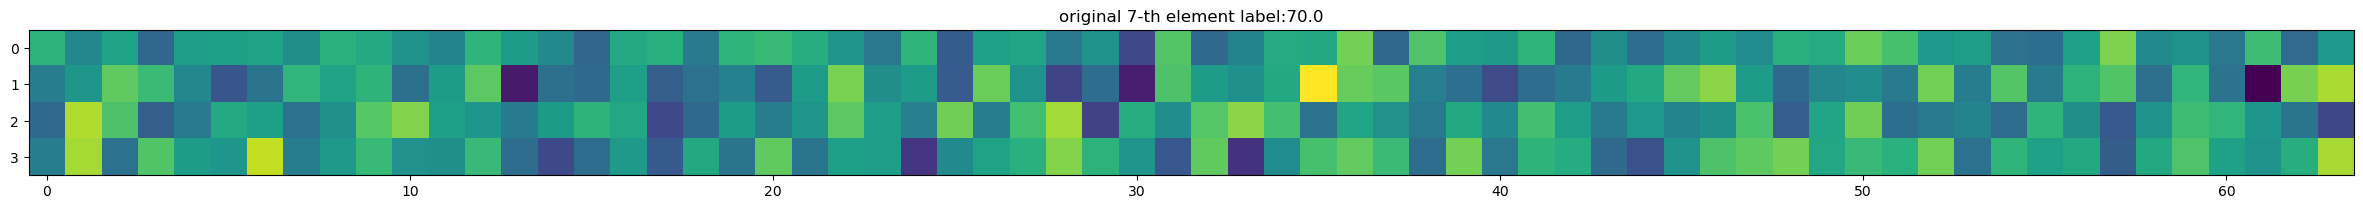

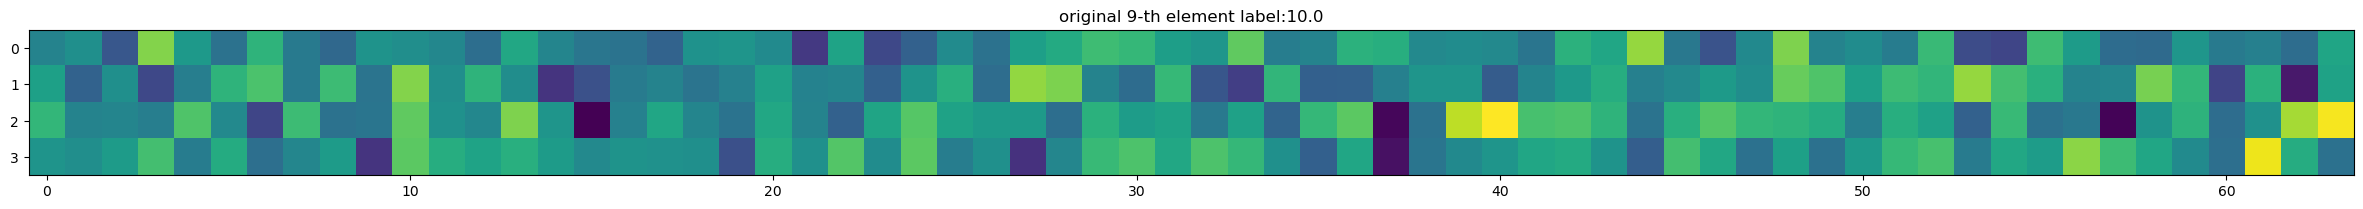

In [24]:
el = [0, 3, 7, 9]
dim = 64

with ExitStack() as stack:
    # get dataloader for corevectors from the original dataset 
    for e in el:
        stack.enter_context(cv) # enter context manager
        cv.load_only(
                loaders = ['train', 'test'],
                verbose = verbose 
                )
        cv_viz = torch.stack((cv._corevds['train']['coreVectors']['features.14'][e][:dim],
                                   cv._corevds['train']['coreVectors']['features.28'][e][:dim],
                                   cv._corevds['train']['coreVectors']['classifier.0'][e][:dim],
                                   cv._corevds['train']['coreVectors']['classifier.3'][e][:dim])                               
                            )
        fig, axs = plt.subplots(1, 1, figsize=(30,10))
        axs.imshow(cv_viz)
        # axs.set_yticks(['features.14', 'features.28', 'classifier.0', 'classifier.3'])
        axs.set_title(f'original {e}-th element label:{cv._corevds['train']['label'][e]}')
    
    # for atk_name in atk_list:
        
    #     fig, axs = plt.subplots(1, 1, figsize=(30,10))
        
    #     if verbose: print(f'\n---------\nLoading dataset for attack: {atk_name}')
    #     stack.enter_context(cv_atks_train[atk_name]) # enter context manager
    #     cv_atks_train[atk_name].load_only(
    #             loaders = ['train', 'test'],
    #             verbose = verbose 
    #             )
    #     cv_viz = torch.stack((cv_atks_train[atk_name]._corevds['train']['coreVectors']['features.14'][el][:dim],
    #                           cv_atks_train[atk_name]._corevds['train']['coreVectors']['features.28'][el][:dim],
    #                           cv_atks_train[atk_name]._corevds['train']['coreVectors']['classifier.0'][el][:dim],
    #                           cv_atks_train[atk_name]._corevds['train']['coreVectors']['classifier.3'][el][:dim])                               
    #                            )
    #     axs.imshow(cv_viz)
    #     axs.set_title(f'{atk_name}')
        
            

In [10]:
mean_diff['PGD']['classifier.0'].shape

torch.Size([4096])

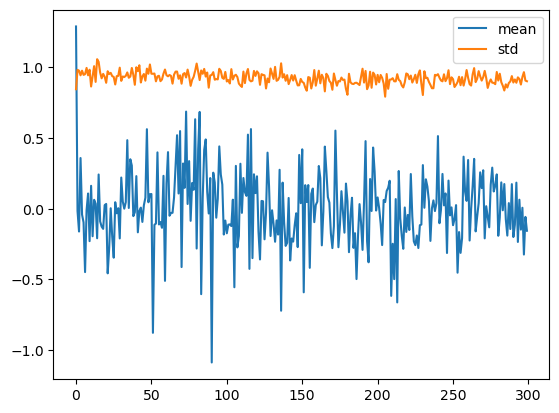

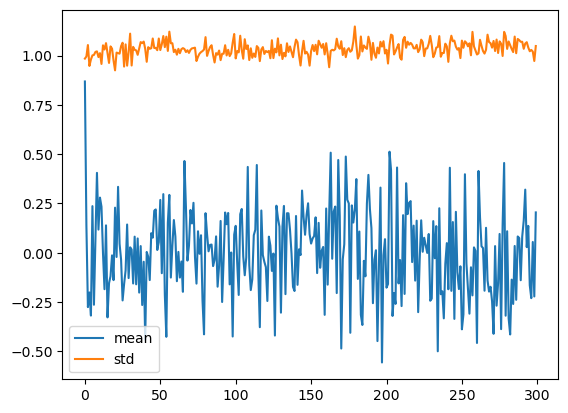

In [13]:
target_layers = ['classifier.0', 'classifier.3']
for atk_name in atk_list:
    for layer in target_layers:
        
        mean = mean_diff[atk_name][layer]
        std = std_diff[atk_name][layer]
        plt.figure()
        plt.plot(mean, label = 'mean')
        plt.plot(std, label = 'std')
        plt.legend()
    break


 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/toy_case/corevectors/CIFAR100/vgg16/corevectors.train exists. Loading from disk.
loaded n_samples:  400

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/toy_case/corevectors/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  100

---------
Loading dataset for attack: PGD

 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/toy_case/corevectors=myPGD/CIFAR100/vgg16/corevectors.train exists. Loading from disk.
loaded n_samples:  400

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/toy_case/corevectors=myPGD/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  100

---------
Loading dataset for attack: BIM

 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/toy_case/corevectors=myBIM/CIFAR100/vgg16/corevectors.train exists. Loading from disk.
loaded n_samples:  400

 ---- Getting data from test


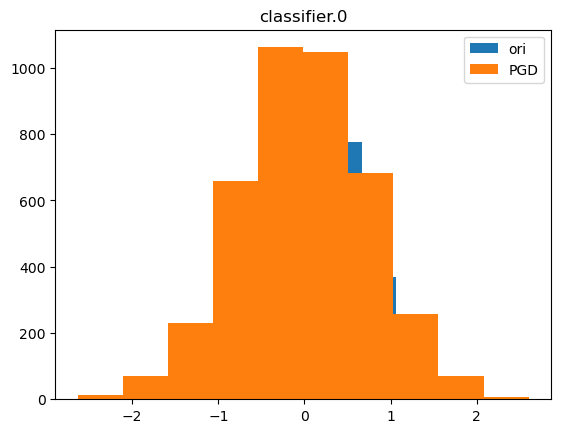

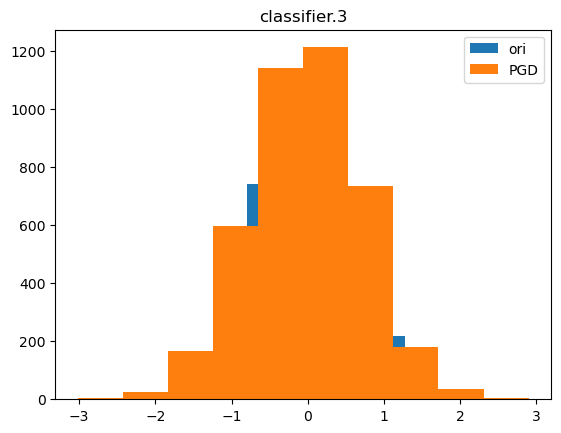

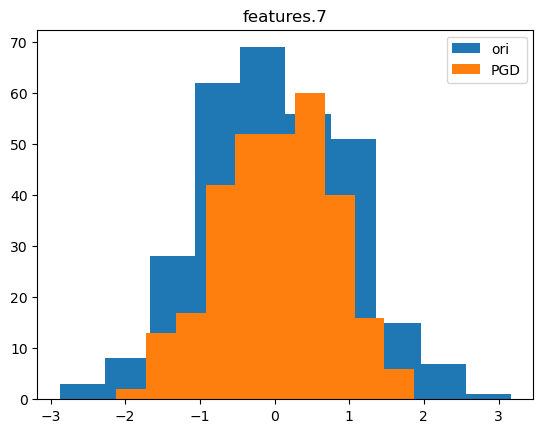

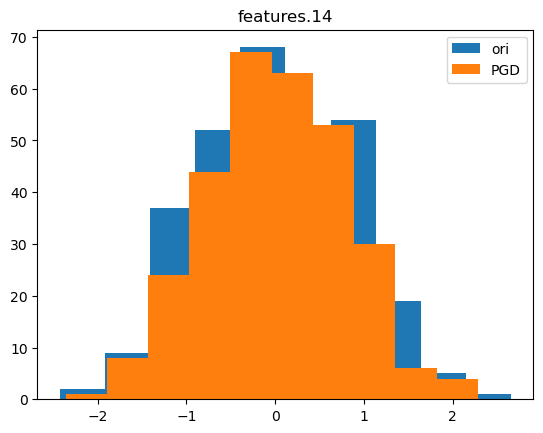

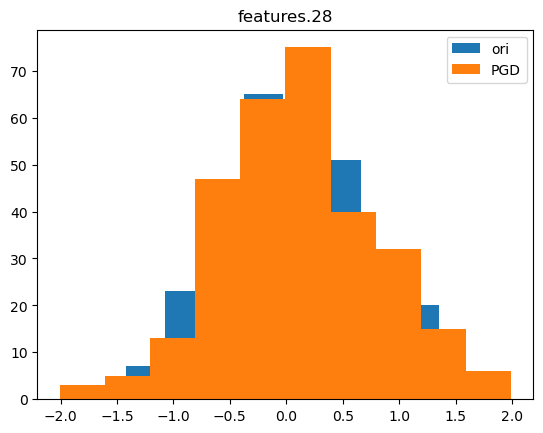

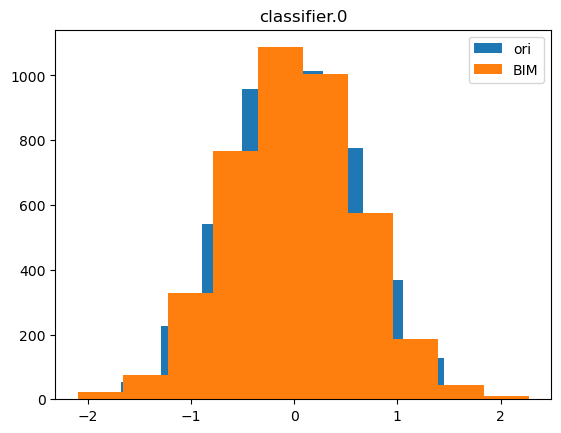

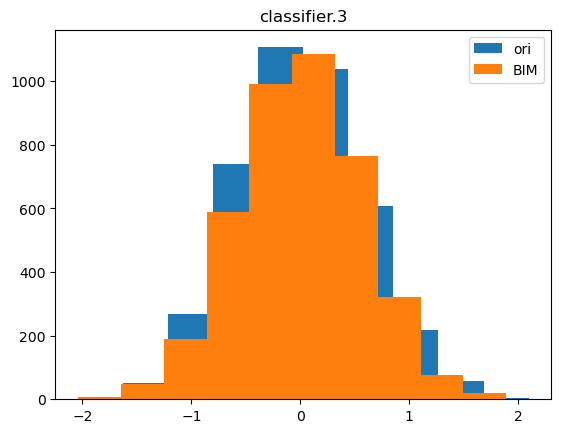

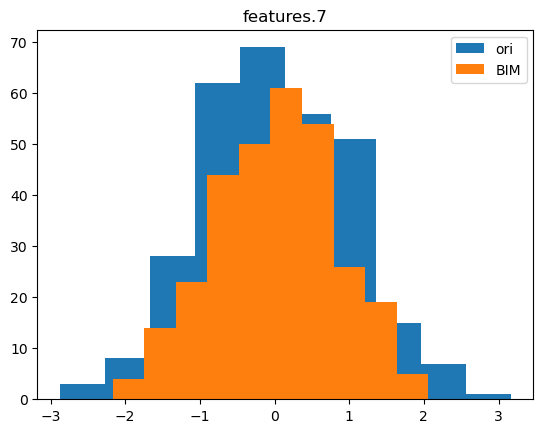

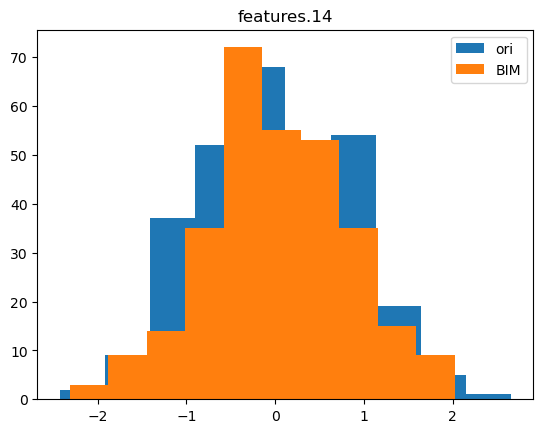

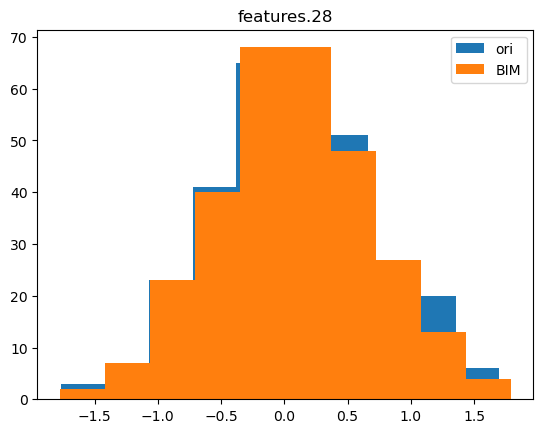

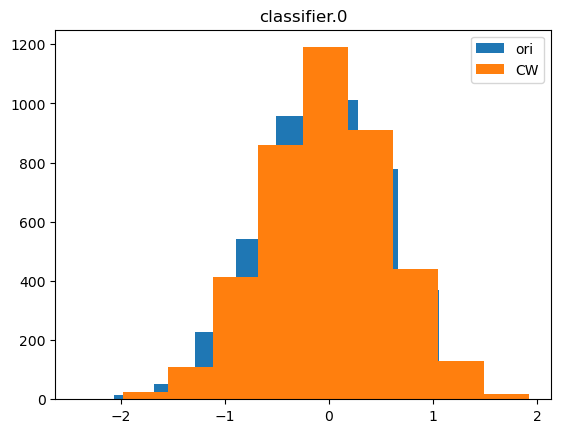

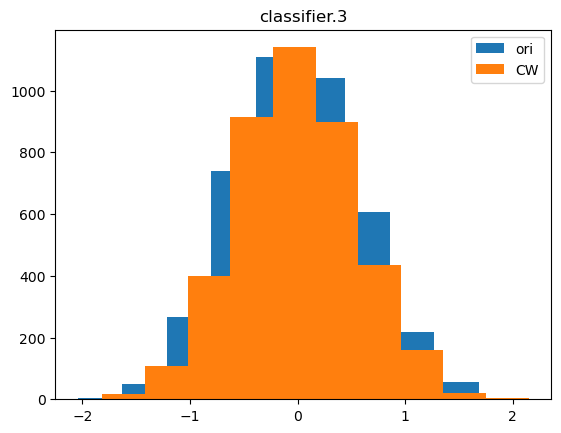

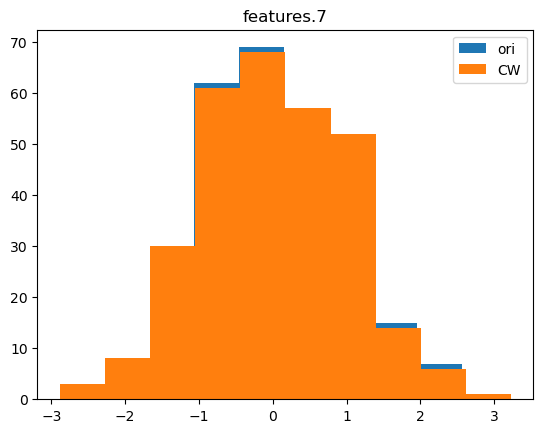

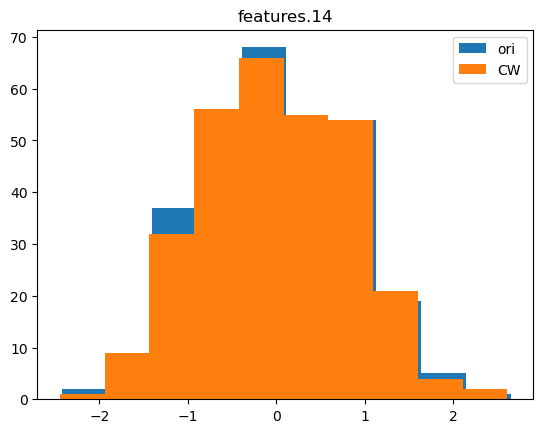

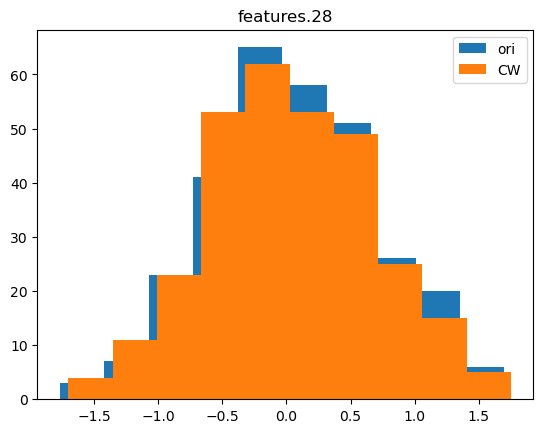

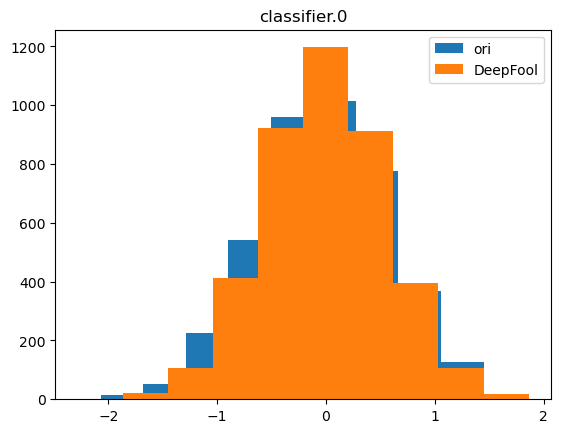

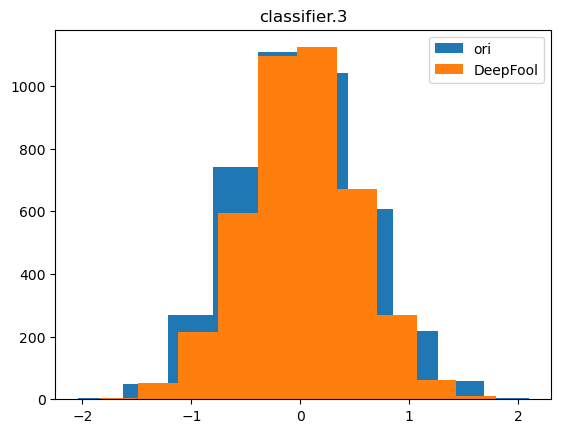

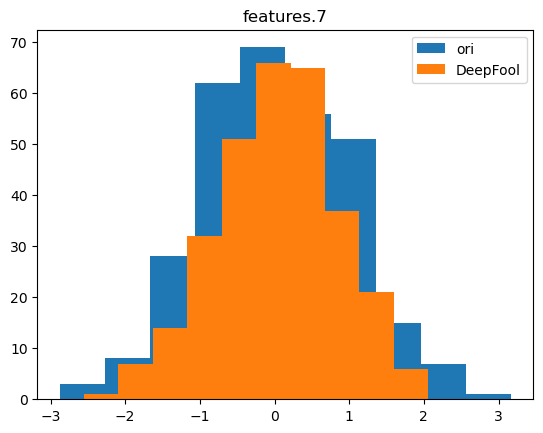

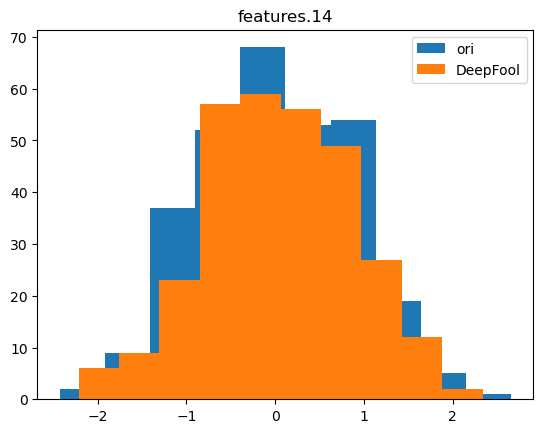

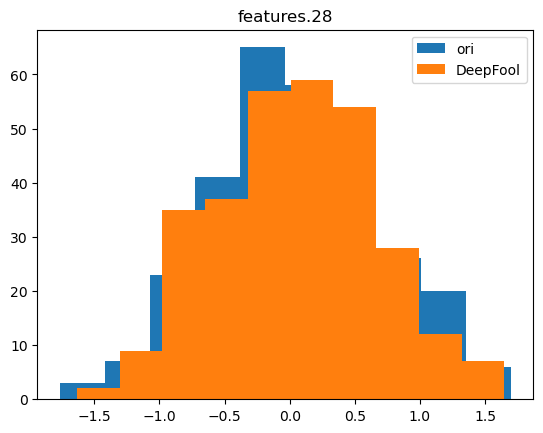

In [25]:
with ExitStack() as stack:
    # get dataloader for corevectors from the original dataset 
    stack.enter_context(cv) # enter context manager
    cv.load_only(
            loaders = ['train', 'test'],
            verbose = verbose 
            )
    mean_diff = {} 
    std_diff = {}
    for atk_name in atk_list:
        if verbose: print(f'\n---------\nLoading dataset for attack: {atk_name}')
        stack.enter_context(cv_atks_train[atk_name]) # enter context manager
        cv_atks_train[atk_name].load_only(
                loaders = ['train', 'test'],
                verbose = verbose 
                )
        mean_diff[atk_name] = {} 
        std_diff[atk_name] = {}
        
        for layer in target_layers:
           
            prova = cv._corevds['train']['coreVectors'][layer]-cv_atks_train[atk_name]._corevds['train']['coreVectors'][layer]
            
            mean_diff[atk_name][layer] = torch.mean(prova, dim=0)
            std_diff[atk_name][layer] = torch.std(prova, dim=0)
    
    el = 300
    for atk_name in atk_list:
        for layer in target_layers:
            prova = cv._corevds['train']['coreVectors'][layer][el]-cv_atks_train[atk_name]._corevds['train']['coreVectors'][layer][el]
            plt.figure()
            plt.hist(cv._corevds['train']['coreVectors'][layer][:][el], label = 'ori')
            plt.hist(cv_atks_train[atk_name]._corevds['train']['coreVectors'][layer][:][el], label = f'{atk_name}')
            plt.title(f'{layer}')
            plt.legend()

# DATAFRAME analysis

In [54]:
results_file = Path('/srv/newpenny/XAI/generated_data/attacks_ijcnn/results_detectors_output_.pk')
df = pd.read_pickle(results_file)

In [57]:
df


,metric,layer,detector,attack
0,0.000000,data,OCSVM,BIM
1,0.000000,data,OCSVM,CW
2,0.000000,data,OCSVM,PGD
3,0.000000,data,OCSVM,DeepFool
4,0.012743,data,LOF,BIM
5,0.013378,data,LOF,CW
6,0.013621,data,LOF,PGD
7,0.013062,data,LOF,DeepFool
8,0.000000,data,IF,BIM
9,0.000000,data,IF,CW


In [13]:
for layer in target_layers:
    df_temp = df[df['layer']==layer]
    df_temp = df_temp.drop('layer', axis=1)

    # 2. Reorder columns so that 'metric' ends up at the end
    cols = [col for col in df_temp.columns if col != 'metric']  # All columns except 'metric'
    df_temp = df_temp[cols + ['metric']]  # Append 'metric' as the last column
    df_pivot = df_temp.pivot(index='detector',
                             columns='attack',
                             values='metric')
    display(df_pivot.style.background_gradient().set_caption(f"Layer {layer}"))
    

attack,BIM,CW,DeepFool,PGD
detector,,,,
IF,0.706154,0.699378,0.875136,0.898429
LOF,0.525038,0.528595,0.598710,0.510926
MD,0.643988,0.689012,0.578436,0.545565
OCSVM,0.750949,0.739655,0.908745,0.929943


attack,BIM,CW,DeepFool,PGD
detector,,,,
IF,0.730042,0.824200,0.883420,0.828995
LOF,0.528149,0.607132,0.691282,0.578128
MD,0.649931,0.724021,0.716091,0.656237
OCSVM,0.731994,0.846318,0.904050,0.824000


attack,BIM,CW,DeepFool,PGD
detector,,,,
IF,0.617252,0.551407,0.560618,0.703057
LOF,0.515868,0.502438,0.512244,0.505184
MD,0.531030,0.523143,0.539967,0.537495
OCSVM,0.525456,0.527450,0.632472,0.568553


attack,BIM,CW,DeepFool,PGD
detector,,,,
IF,0.678177,0.604802,0.864084,0.907309
LOF,0.565114,0.535383,0.664260,0.693034
MD,0.541171,0.542604,0.533311,0.505173
OCSVM,0.685905,0.612873,0.877534,0.915238


In [14]:
dfs = []
for layer in target_layers:
    # 1. Filter for the current layer
    df_temp = df[df['layer'] == layer].drop(columns='layer')

    # 2. Reorder columns so that 'metric' ends up at the end
    cols = [c for c in df_temp.columns if c != 'metric']
    df_temp = df_temp[cols + ['metric']]

    # 3. Pivot
    df_pivot = df_temp.pivot(index='detector', columns='attack', values='metric')

    # 4. Convert the index to a MultiIndex that includes the layer
    df_pivot.index = pd.MultiIndex.from_product(
        [[layer], df_pivot.index],
        names=['layer', 'detector']
    )

    dfs.append(df_pivot)

# 5. Concatenate along the row axis
df_concat = pd.concat(dfs, axis=0)

display(df_concat)

attack                      BIM        CW  DeepFool       PGD
layer        detector                                        
classifier.0 IF        0.706154  0.699378  0.875136  0.898429
             LOF       0.525038  0.528595  0.598710  0.510926
             MD        0.643988  0.689012  0.578436  0.545565
             OCSVM     0.750949  0.739655  0.908745  0.929943
classifier.3 IF        0.730042  0.824200  0.883420  0.828995
             LOF       0.528149  0.607132  0.691282  0.578128
             MD        0.649931  0.724021  0.716091  0.656237
             OCSVM     0.731994  0.846318  0.904050  0.824000
features.14  IF        0.617252  0.551407  0.560618  0.703057
             LOF       0.515868  0.502438  0.512244  0.505184
             MD        0.531030  0.523143  0.539967  0.537495
             OCSVM     0.525456  0.527450  0.632472  0.568553
features.28  IF        0.678177  0.604802  0.864084  0.907309
             LOF       0.565114  0.535383  0.664260  0.693034
             MD        0.541171  0.542604  0.533311  0.505173
             OCSVM     0.685905  0.612873  0.877534  0.915238

In [31]:
dfs = []
for layer in target_layers:
    # Filter for the current layer (drop 'layer' from columns as well)
    df_temp = df[df['layer'] == layer].drop(columns='layer')

    # Reorder columns so 'metric' ends up last
    cols = [c for c in df_temp.columns if c != 'metric']
    df_temp = df_temp[cols + ['metric']]
    
    # Pivot on (detector, attack) -> metric
    df_pivot = df_temp.pivot(index='detector', columns='attack', values='metric')
    
    # Add the layer as an additional level of columns
    df_pivot.columns = pd.MultiIndex.from_product(
        [[layer], df_pivot.columns],
        names=['layer', 'attack']
    )
    
    dfs.append(df_pivot)

# Concatenate along columns so that layers become higher-level columns
df_concat = pd.concat(dfs, axis=1).round(3)

display(df_concat.style.background_gradient(axis=None))


In [19]:
df_concat.to_csv("concat_v1.csv")

In [163]:
dfs = []
for detector in detector_list:
    # Filter for the current layer (drop 'layer' from columns as well)
    df_temp = df[df['detector'] == detector].drop(columns='detector')

    # Reorder columns so 'metric' ends up last
    cols = [c for c in df_temp.columns if c != 'metric']
    df_temp = df_temp[cols + ['metric']]
    
    # Pivot on (detector, attack) -> metric
    df_pivot = df_temp.pivot(index='layer', columns='attack', values='metric')
    
    # Add the layer as an additional level of columns
    df_pivot.columns = pd.MultiIndex.from_product(
        [[detector], df_pivot.columns],
        names=['detector', 'attack']
    )
    
    dfs.append(df_pivot)

# Concatenate along columns so that layers become higher-level columns
df_concat = pd.concat(dfs, axis=1).round(3)

display(df_concat.style.background_gradient())

In [6]:
desired_order = ['features.14', 'features.28', 'classifier.0', 'classifier.3']
df_concat = df_concat.reindex(desired_order)
display(df_concat.style.background_gradient(axis=None))

In [7]:
df_concat.to_csv("concat_v1.csv")

# Visualization of the ouput

In [70]:
name_model = 'vgg16'
dataset = 'CIFAR100' 
verbose = True

results_path = Path.cwd()/'results/ml'
results_name = 'results_detectors.pk'

cvs_name = 'output'
cvs_path = f'/srv/newpenny/XAI/generated_data/corevectors/{dataset}/{name_model}'

cvs_atks_home = f'/srv/newpenny/XAI/generated_data'

verbose = True
attack_names = ['BIM', 'CW', 'PGD', 'DeepFool']
metric_type = 'AUC'#, P_D

# detector_configs = pandas.read_pickle(results_path/'tuning_results/best_configs_output.pk') 
# for k, v in detector_configs.items():
#     print('\n', k)
#     for kk, vv in v.items():
#         print(kk)
#         print(vv)
# #--------------------------------
# # Detectors 
# #--------------------------------
# if verbose: print('Creating detectors')
# detectors = {}
# for _det_name in detector_configs:
#     detectors[_det_name] = {}
#     for _layer in detector_configs[_det_name]:
#         conf = detector_configs[_det_name][_layer].copy()
#         conf.pop('cv_size')
#         detectors[_det_name][_layer] = eval(_det_name)(**conf)

#--------------------------------
# CoreVectors 
#--------------------------------
cv = CoreVectors(
        path = cvs_path,
        name = 'corevectors',
        verbose = verbose
        )
out = CoreVectors(
        path = cvs_path,
        name = 'output',
        verbose = verbose
            )
    

In [71]:
cv_atks = {} 
out_atks = {}
for atk_name in attack_names:
    cv_atk_path = cvs_atks_home+f'/corevectors_attacks=my{atk_name}/{dataset}/{name_model}'
    cv_atks[atk_name] = CoreVectors(
            path = cv_atk_path,
            name = 'corevectors',
            verbose = verbose
            ) 

    out_atks[atk_name] = CoreVectors(
            path = cv_atk_path,
            name = 'output',
            verbose = verbose
            ) 


 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/corevectors.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/output.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/output.test exists. Loading from disk.
loaded n_samples:  10000

---------
Loading dataset for attack: BIM

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors_attacks=myBIM/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors_attacks=myBIM/CIFAR100/vgg16/output.test ex

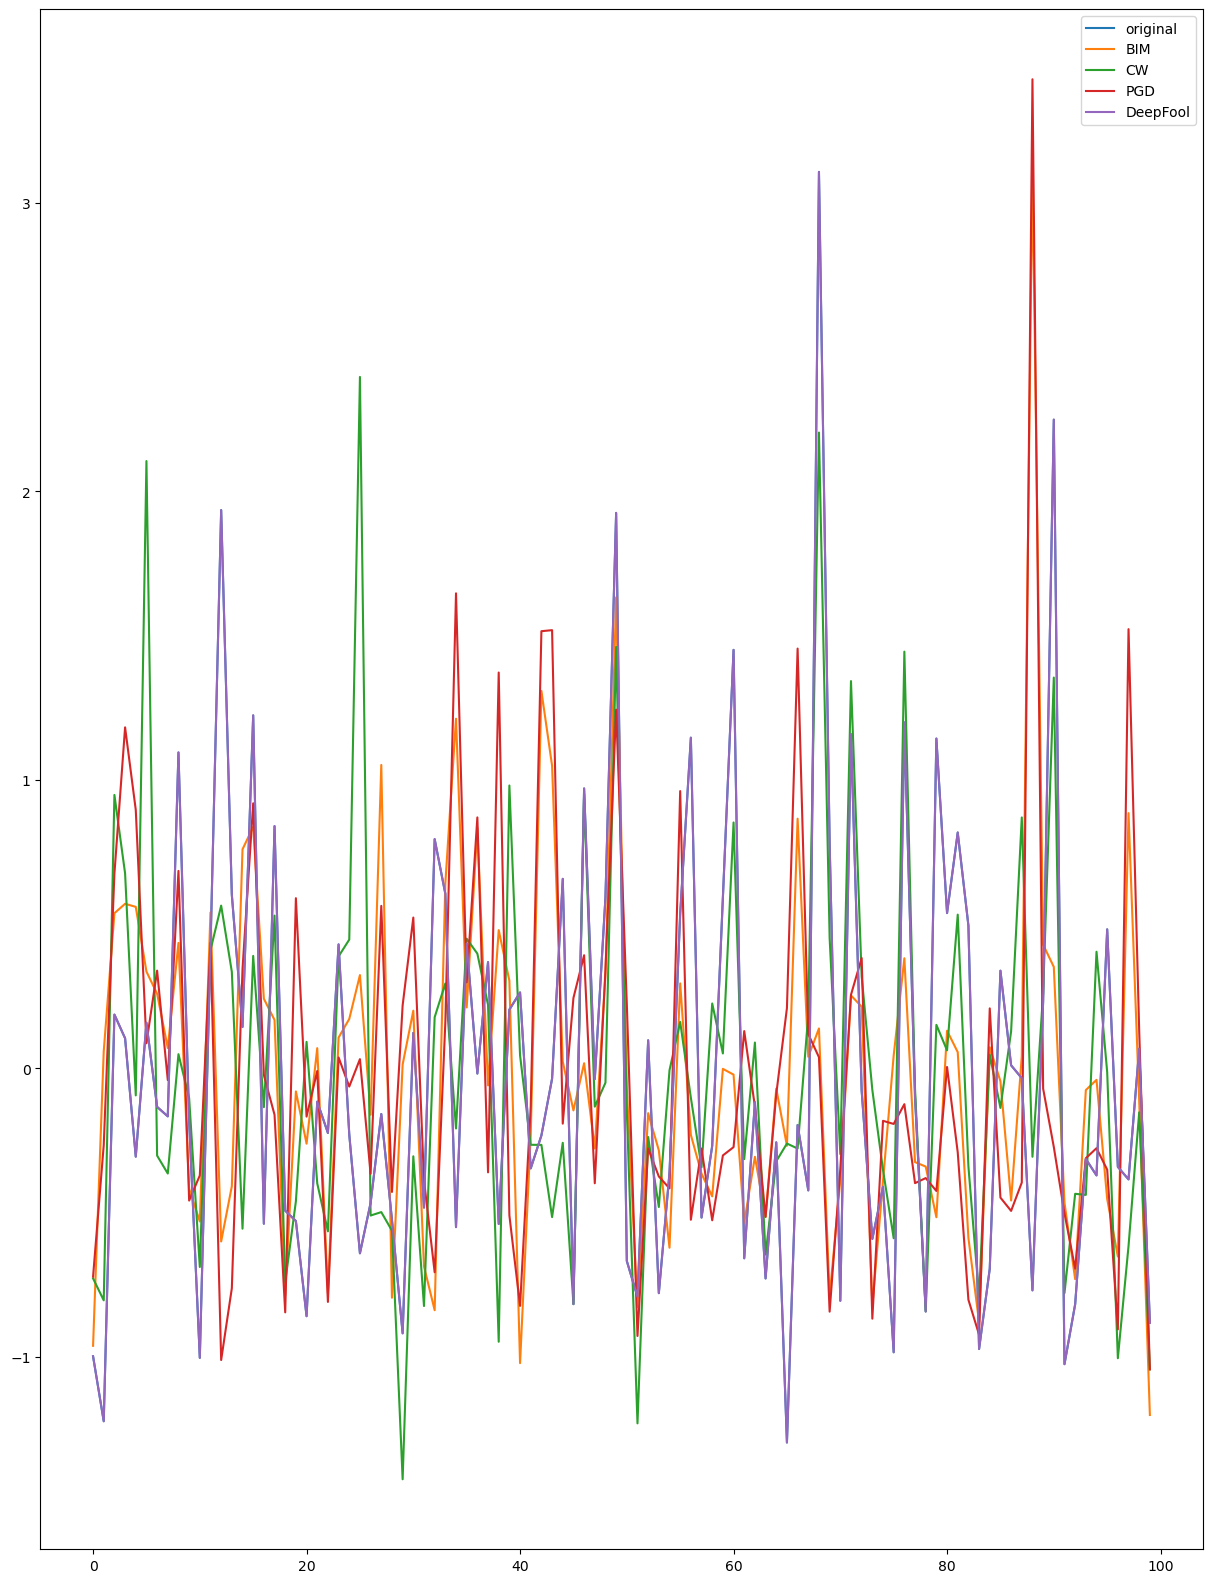

In [75]:
with cv, out:
    # get dataloader for corevectors from the original dataset 
    cv.load_only(
            loaders = ['train', 'test'],
            verbose = verbose 
            ) 
    out.load_only(
            loaders = ['train', 'test'],
            verbose = verbose 
            ) 
    fig, axs = plt.subplots(1, 1, figsize=(15,20))
    axs.plot(out._corevds['test']['coreVectors']['data'][0], label='original')
    for i, _atk_name in enumerate(attack_names):
                    # get dataloader for corevectors from atks dataset 
                    
        with cv_atks[_atk_name] as cv_atk, out_atks[_atk_name] as out_atk:
            if verbose: print(f'\n---------\nLoading dataset for attack: {_atk_name}')
            cv_atk.load_only(
                    loaders = ['test'],
                    verbose = verbose 
                    )
            out_atk.load_only(
                    loaders = ['test'],
                    verbose = verbose 
                    )
            axs.plot(out_atk._corevds['test']['coreVectors']['data'][0], label=f'{_atk_name}')
    axs.legend()       
    

# Visualization of attacks

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device(auto_cuda('utilization')) if use_cuda else torch.device("cpu")
print(f"Using {device} device")

#--------------------------------
# Directories definitions
#--------------------------------
ds_path = '/srv/newpenny/dataset/CIFAR100'
name_model = 'vgg16'
dataset = 'CIFAR100' 
seed = 29
bs = 64 
model_dir = '/srv/newpenny/XAI/models'
model_name = 'LM_model=vgg16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau.pth'

verbose = True

svds_path = Path.cwd()/f'../../../XAI/generated_data/svds/{dataset}/{name_model}'
svds_name = 'svds' 

cvs_path = f'/srv/newpenny/XAI/generated_data/toy_case_{dataset}/corevectors/{dataset}/{name_model}'
cvs_name = 'corevectors'
#--------------------------------
# Dataset 
#--------------------------------

ds = Cifar(dataset=dataset, data_path=ds_path)
ds.load_data(
        batch_size = bs,
        data_kwargs = {'num_workers': 4, 'pin_memory': True},
        seed = seed,
        )

#--------------------------------
# Model 
#--------------------------------

nn = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
in_features = 4096
num_classes = len(ds.get_classes()) 
nn.classifier[-1] = torch.nn.Linear(in_features, num_classes)
model = ModelWrap(device=device)
model.set_model(model=nn, path=model_dir, name=model_name, verbose=True)




Using cuda:1 device
dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified


/srv/newpenny/conda/envs/xai-venv/lib/python3.12/site-packages/peepholelib/models/model_wrap.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._checkpoint = torch.l


-----------------
checkpoint
-----------------
state_dict keys: 
 odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias']) 

epoch 58
initial_lr 0.001
final_lr 1e-05
train_accuracy 93.895
val_accuracy 95.53
loss_plot b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01\xe0\x08\x06\x00\x00\x005\xd1\xdc\xe4\x00\x00\x009tEXtSoftware\x00Matplotlib version3.9.2, 

In [11]:
ds_loaders = ds.get_dataset_loaders()
loaders = {'train': ds_loaders['train'],
          'test': ds_loaders['test']}

In [76]:
# Attcks
import torchattacks
from peepholelib.adv_atk.attacks_base import ftd
from peepholelib.adv_atk.PGD import myPGD
from peepholelib.adv_atk.BIM import myBIM
from peepholelib.adv_atk.DeepFool import myDeepFool
from peepholelib.adv_atk.CW import myCW

SM = torch.nn.Softmax(dim=0)

In [13]:
atcks = {
         'myPGD':
                 {'model': model._model,
                  'eps' : 8/255, 
                  'alpha' : 2/255, 
                  'steps' : 10,
                  'device' : device,
                  'path' : f'/srv/newpenny/XAI/generated_data/attacks/PGD',
                  'name' : 'PGD',
                  'dl' : loaders,
                  'name_model' : name_model,
                  'verbose' : True,
                  'mode' : 'random',},
         'myBIM': 
                 {'model': model._model,
                  'eps' : 8/255, 
                  'alpha' : 2/255, 
                  'steps' : 10,
                  'device' : device,
                  'path' : f'/srv/newpenny/XAI/generated_data/attacks/BIM',
                  'name' : 'BIM',
                  'dl' : loaders,
                  'name_model' : name_model,
                  'verbose' : True,
                  'mode' : 'random',},
         'myCW':{
                  'model': model._model,
                  'device' : device,
                  'path' : f'/srv/newpenny/XAI/generated_data/attacks/CW',
                  'name' : 'CW',
                  'dl' : loaders,
                  'name_model' : name_model,
                  'verbose' : True,
                  'nb_classes' : ds.config['num_classes'],
                  'confidence': 0,
                  'c_range': (1e-3, 1e10),
                  'max_steps': 1000,
                  'optimizer_lr': 1e-2,
                  'verbose': True,},
         'myDeepFool':{
                       'model': model._model,
                        'steps' : 50,
                        'overshoot' : 0.02,
                        'device' : device,
                        'path' : f'/srv/newpenny/XAI/generated_data/attacks/DeepFool',
                        'name' : 'DeepFool',
                        'dl' : loaders,
                        'name_model' : name_model,
                        'verbose' : True,
                        }
              }

atk_loaders = {}
for atk_type, kwargs in atcks.items():
    atk = eval(atk_type)(**kwargs)

    if not atk.atk_path.exists():
        atk.get_ds_attack()
    
    atk_loaders[atk_type] = {key: DataLoader(value, batch_size=bs, collate_fn = lambda x: x, shuffle=False) for key, value in atk._atkds.items()}

---------- Attack PGD init

File /srv/newpenny/XAI/generated_data/attacks/PGD/model_vgg16/eps_0.03/alpha_0.01/steps_10/random_start_True exists.
---------- Attack BIM init

File /srv/newpenny/XAI/generated_data/attacks/BIM/model_vgg16/eps_0.03/alpha_0.01/steps_10 exists.
---------- Attack CW init

File /srv/newpenny/XAI/generated_data/attacks/CW/model_vgg16/confidence_0/c_range_(0.001, 10000000000.0)/max_steps_1000/optimizer_lr_0.01 exists.
---------- Attack DeepFool init

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f34880c7e00>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f3434535760>}
File /srv/newpenny/XAI/generated_data/attacks/DeepFool/model_vgg16/steps_50/overshoot_0.02 exists.


In [83]:
idx = 13
portion = 'test'

cmap = 'hot'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.392942..1.9757491].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.350196..1.0].


torch.Size([64, 3, 224, 224])
torch.Size([3, 224, 224])


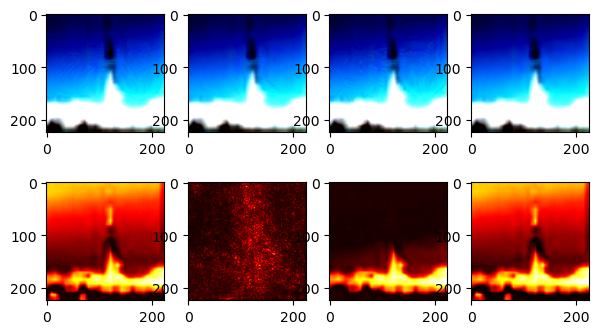

In [84]:
data_iter = iter(ds_loaders[portion])
ori_image, label = next(data_iter)

PGD_iter = iter(atk_loaders['myPGD'][portion])
PGD_image = next(PGD_iter)['image']
print(ori_image.shape)
print((PGD_image[idx]-ori_image[idx]).shape)

CW_iter = iter(atk_loaders['myCW'][portion])
CW_image = next(CW_iter)['image']

BIM_iter = iter(atk_loaders['myBIM'][portion])
BIM_image = next(BIM_iter)['image']

DeepFool_iter = iter(atk_loaders['myDeepFool'][portion])
DeepFool_image = next(DeepFool_iter)['image']

fig, ax = plt.subplots(2, 4, figsize=(7,4))

ax[0,0].imshow(np.transpose(PGD_image[idx], (1, 2, 0)))
ax[1,0].imshow(torch.abs(ori_image[idx]-PGD_image[idx]).mean(dim=0),cmap=cmap)

ax[0,1].imshow(np.transpose(CW_image[idx], (1, 2, 0)))
ax[1,1].imshow(torch.abs(ori_image[idx]-CW_image[idx]).mean(dim=0),cmap=cmap)

ax[0,2].imshow(np.transpose(BIM_image[idx], (1, 2, 0)))
ax[1,2].imshow(torch.abs(ori_image[idx]-BIM_image[idx]).mean(dim=0),cmap=cmap)

ax[0,3].imshow(np.transpose(DeepFool_image[idx], (1, 2, 0)))
ax[1,3].imshow(torch.abs(ori_image[idx]-DeepFool_image[idx]).mean(dim=0),cmap=cmap)


In [123]:
cifar100_classes = [
    'Apple', 'Aquarium_fish', 'Baby', 'Bear', 'Beaver', 'Bed', 'Bee', 'Beetle', 
    'Bicycle', 'Bottle', 'Bowl', 'Boy', 'Bridge', 'Bus', 'Butterfly', 'Damel', 
    'Dan', 'Dastle', 'Daterpillar', 'Dattle', 'Dhair', 'Dhimpanzee', 'Dlock', 
    'Dloud', 'Dockroach', 'Douch', 'Drab', 'Drocodile', 'Dup', 'Dinosaur', 
    'Dolphin', 'Elephant', 'Flatfish', 'Forest', 'Fox', 'Girl', 'Hamster', 
    'House', 'Kangaroo', 'Keyboard', 'Lamp', 'Lawn_mower', 'Leopard', 'Lion',
    'Lizard', 'Lobster', 'Man', 'Maple_tree', 'Motorcycle', 'Mountain', 'Mouse',
    'Mushroom', 'Oak_tree', 'Orange', 'Orchid', 'Otter', 'Palm_tree', 'Pear',
    'Pickup_truck', 'Pine_tree', 'Plain', 'Plate', 'Poppy', 'Porcupine',
    'Possum', 'Rabbit', 'Raccoon', 'Ray', 'Road', 'Rocket', 'Rose',
    'Sea', 'Seal', 'Shark', 'Shrew', 'Skunk', 'Skyscraper', 'Snail', 'Snake',
    'Spider', 'Squirrel', 'Streetcar', 'Sunflower', 'Sweet_pepper', 'Table',
    'Tank', 'Telephone', 'Television', 'Tiger', 'Tractor', 'Train', 'Trout',
    'Tulip', 'Turtle', 'Wardrobe', 'Whale', 'Willow_tree', 'Wolf', 'Woman',
    'Worm'
]

# Create a dictionary where each key is the numeric class and the value is the class name
class_dict = {i: cifar100_classes[i] for i in range(len(cifar100_classes))}

print(class_dict)

{0: 'Apple', 1: 'Aquarium_fish', 2: 'Baby', 3: 'Bear', 4: 'Beaver', 5: 'Bed', 6: 'Bee', 7: 'Beetle', 8: 'Bicycle', 9: 'Bottle', 10: 'Bowl', 11: 'Boy', 12: 'Bridge', 13: 'Bus', 14: 'Butterfly', 15: 'Damel', 16: 'Dan', 17: 'Dastle', 18: 'Daterpillar', 19: 'Dattle', 20: 'Dhair', 21: 'Dhimpanzee', 22: 'Dlock', 23: 'Dloud', 24: 'Dockroach', 25: 'Douch', 26: 'Drab', 27: 'Drocodile', 28: 'Dup', 29: 'Dinosaur', 30: 'Dolphin', 31: 'Elephant', 32: 'Flatfish', 33: 'Forest', 34: 'Fox', 35: 'Girl', 36: 'Hamster', 37: 'House', 38: 'Kangaroo', 39: 'Keyboard', 40: 'Lamp', 41: 'Lawn_mower', 42: 'Leopard', 43: 'Lion', 44: 'Lizard', 45: 'Lobster', 46: 'Man', 47: 'Maple_tree', 48: 'Motorcycle', 49: 'Mountain', 50: 'Mouse', 51: 'Mushroom', 52: 'Oak_tree', 53: 'Orange', 54: 'Orchid', 55: 'Otter', 56: 'Palm_tree', 57: 'Pear', 58: 'Pickup_truck', 59: 'Pine_tree', 60: 'Plain', 61: 'Plate', 62: 'Poppy', 63: 'Porcupine', 64: 'Possum', 65: 'Rabbit', 66: 'Raccoon', 67: 'Ray', 68: 'Road', 69: 'Rocket', 70: 'Rose', 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3815686..1.9589837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.392942..1.9757491].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.350196..1.0].


tensor(0.9873, device='cuda:1', grad_fn=<SelectBackward0>)


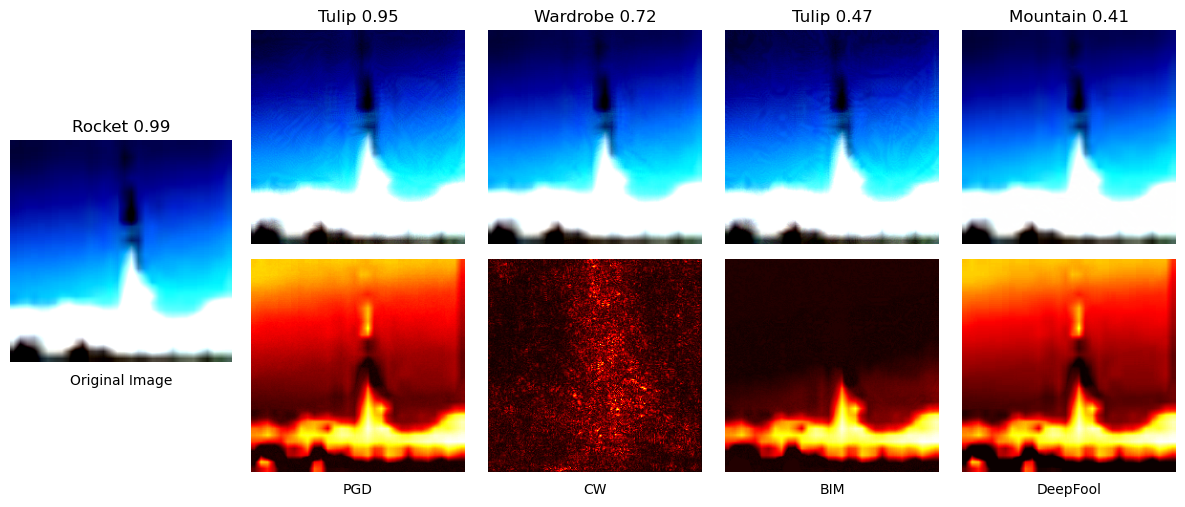

In [151]:
import matplotlib.gridspec as gridspec

# Example: main_image could be your original image or anything else you'd like
# to show in the left column. Here, just a dummy NumPy array for illustration.
SM = torch.nn.Softmax(dim=0)
main_image = ori_image[idx]
output = torch.max(SM(model._model(ori_image.to(device))),axis=0)[0][idx]

print(output)
# Example dictionary of attacks (tuples of (attacked_image, difference_map))
small_images = {
    'PGD'     : (PGD_image[idx], torch.abs(ori_image[idx] - PGD_image[idx]).mean(dim=0)),
    'CW'      : (CW_image[idx],  torch.abs(ori_image[idx] - CW_image[idx]).mean(dim=0)),
    'BIM'     : (BIM_image[idx], torch.abs(ori_image[idx] - BIM_image[idx]).mean(dim=0)),
    'DeepFool': (DeepFool_image[idx], torch.abs(ori_image[idx] - DeepFool_image[idx]).mean(dim=0)),
}

# Create a figure
fig = plt.figure(figsize=(12, 5))

# Create a 2-row, 5-column GridSpec
#   - We'll put the "main image" in the first column (col=0), spanning both rows.
#   - The remaining 4 columns (col=1..4) will each contain two subplots (row=0 for attacked, row=1 for diff).
gs = gridspec.GridSpec(2, 5, figure=fig)

# 1) Main image (left side), spanning both rows in the first column
ax_main = fig.add_subplot(gs[:, 0])  # all rows (:), col 0
ax_main.imshow(np.transpose(main_image, (1,2,0)))
ax_main.set_title(f"{class_dict[int(label[idx])]} {output:.2f}")
ax_main.axis('off')
ax_main.annotate(
        'Original Image',
        xy=(0.5, -0.05),
        xycoords='axes fraction',
        ha='center',
        va='top',
        fontsize=10  # adjust as needed
    )

# 2) For each attack in small_images, we place:
#    - The attacked image on the top row (row=0)
#    - The difference map on the bottom row (row=1)
#    starting from col=1 up to col=4.
col_idx_start = 1
for col_offset, (attack_name, (attacked_img, diff_img)) in enumerate(small_images.items()):
    col_idx = col_idx_start + col_offset  # 1, 2, 3, 4

    # ----- Top row: Attacked image -----
    ax_top = fig.add_subplot(gs[0, col_idx])
    # If attacked_img is a 3×H×W tensor, convert to H×W×3 for imshow
    if attacked_img.ndim == 3 and attacked_img.shape[0] in [1, 3]:
        attacked_np = attacked_img.permute(1, 2, 0).detach().cpu().numpy()
        # If in [0, 1], it's directly usable for imshow
    else:
        # If it's already H×W or H×W×3 as numpy, adapt as needed
        attacked_np = attacked_img.detach().cpu().numpy()

    o = model._model(attacked_img.unsqueeze(dim=0).to(device))
    SM = torch.nn.Softmax(dim=1)
    ou = SM(o).squeeze()

    output, pred = torch.max(ou,dim=0)

    ax_top.imshow(attacked_np)
    ax_top.set_title(f"{class_dict[int(pred)]} {output:.2f}")
    ax_top.axis('off')

    # ----- Bottom row: Difference map -----
    ax_bottom = fig.add_subplot(gs[1, col_idx])
    diff_np = diff_img.detach().cpu().numpy()
    ax_bottom.imshow(diff_np, cmap='hot')
    ax_bottom.axis('off')
    ax_bottom.annotate(
        attack_name,
        xy=(0.5, -0.05),
        xycoords='axes fraction',
        ha='center',
        va='top',
        fontsize=10  # adjust as needed
    )

plt.tight_layout()
plt.show()
fig.savefig('confronto.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3815686..1.9589837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.392942..1.9757491].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.350196..1.0].
/tmp/ipykernel_3953688/37566295.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=0.001)


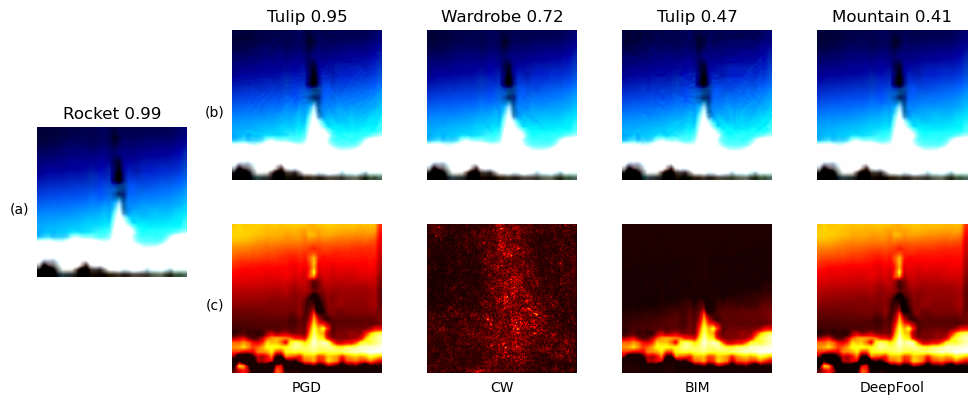

In [160]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

SM = torch.nn.Softmax(dim=0)
main_image = ori_image[idx]
# Show softmax max class and score for the original image
output = torch.max(SM(model._model(ori_image.to(device))), axis=0)[0][idx]

small_images = {
    'PGD'     : (PGD_image[idx], torch.abs(ori_image[idx] - PGD_image[idx]).mean(dim=0)),
    'CW'      : (CW_image[idx],  torch.abs(ori_image[idx] - CW_image[idx]).mean(dim=0)),
    'BIM'     : (BIM_image[idx], torch.abs(ori_image[idx] - BIM_image[idx]).mean(dim=0)),
    'DeepFool': (DeepFool_image[idx], torch.abs(ori_image[idx] - DeepFool_image[idx]).mean(dim=0)),
}

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(2, 5, figure=fig)
gs.update(wspace=0.3, hspace=0.01)

# --- (A) MAIN IMAGE (LEFT COLUMN) ---
ax_main = fig.add_subplot(gs[:, 0])
ax_main.imshow(main_image.permute(1, 2, 0).cpu().numpy())
ax_main.set_title(f"{class_dict[int(label[idx])]} {output:.2f}")
ax_main.axis('off')

# Label (a) on the left side (slightly outside the top-left corner)
ax_main.text(
    -0.05, 0.5,         # (x, y) in axes coords; negative x => left of the axis
    '(a)', 
    transform=ax_main.transAxes, 
    # fontsize=12, 
    # fontweight='bold', 
    ha='right',        # align text to the right (since x is negative)
    va='top'
)

col_idx_start = 1
for col_offset, (attack_name, (attacked_img, diff_img)) in enumerate(small_images.items()):
    col_idx = col_idx_start + col_offset  # 1..4

    # ------------------ TOP ROW: Attacked image ------------------
    ax_top = fig.add_subplot(gs[0, col_idx])

    # Convert (3,H,W) -> (H,W,3) if needed
    if attacked_img.ndim == 3 and attacked_img.shape[0] in [1, 3]:
        attacked_np = attacked_img.permute(1, 2, 0).detach().cpu().numpy()
    else:
        attacked_np = attacked_img.detach().cpu().numpy()

    # Get predicted label & confidence
    logits = model._model(attacked_img.unsqueeze(dim=0).to(device))
    SM_ = torch.nn.Softmax(dim=1)
    probs = SM_(logits).squeeze()
    out_score, pred = torch.max(probs, dim=0)

    ax_top.imshow(attacked_np)
    ax_top.set_title(f"{class_dict[int(pred)]} {out_score:.2f}")
    ax_top.axis('off')

    # Place label (b) on the first column of the top row only
    if col_offset == 0:  
        ax_top.text(
            -0.05, 0.5, 
            '(b)', 
            transform=ax_top.transAxes, 
            # fontsize=12, 
            # fontweight='bold', 
            ha='right', 
            va='top'
        )

    # ----------------- BOTTOM ROW: Difference map ----------------
    ax_bottom = fig.add_subplot(gs[1, col_idx])
    diff_np = diff_img.detach().cpu().numpy()
    ax_bottom.imshow(diff_np, cmap='hot')
    ax_bottom.axis('off')

    ax_bottom.annotate(
        attack_name,
        xy=(0.5, -0.05),
        xycoords='axes fraction',
        ha='center',
        va='top',
        fontsize=10  # adjust as needed
    )

    # Place label (c) on the first column of the bottom row only
    if col_offset == 0:
        ax_bottom.text(
            -0.05, 0.5, 
            '(c)', 
            transform=ax_bottom.transAxes, 
            # fontsize=12, 
            # fontweight='bold', 
            ha='right', 
            va='top'
        )

plt.tight_layout(h_pad=0.001)
# plt.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.9)
plt.show()
fig.savefig('confronto.png')